In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=32)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=20)
parser.add_argument("--Re", type=int, default=100)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.005)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
print(collision_operator)
print(torch.version.cuda)

ICH FUNKTIONIERE MIT PULLEN
BGK
12.1


In [3]:
print(torch.cuda._parse_visible_devices())
print(Precision)
if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16
lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=dtype)
flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice)

# Konstruktion des Funktionsnamens
function_name = f"{collision_operator}Collision"

# Überprüfung, ob die Funktion existiert, und deren Aufruf
#if hasattr(lt, function_name):
#    collision = getattr(lt, function_name)(lattice, tau=flow.units.relaxation_parameter_lu)
#    print(collision_operator)
#else:
#    print(":(((")
#    raise ValueError(f"Collision type {collision_operator} is not supported.")
if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=round(flow.units.relaxation_parameter_lu,7))
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)
#collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
#collision=collision_type(lattice, tau=flow.units.relaxation_parameter_lu)
print(round(flow.units.relaxation_parameter_lu,7))
print(flow.units.viscosity_pu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
Double
0.5004411
0.01


In [4]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/20)
interval_out=int((flow.units.convert_time_to_lu(tmax))/500)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_sij(lattice, flow)
Enstrophy=lt.Enstrophy(lattice, flow)
Energyspectrum= lt.EnergySpectrum2(lattice, flow)
Symmetrie= lt.SymmetryReporter(lattice,flow)
#SymmetrieCoords = lt.SymmetryTopPercentageReporter(lattice,flow)
interval_out=int((flow.units.convert_time_to_lu(tmax))/500)

reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2 = lt.ObservableReporter(Dissipation_TGV,interval = interval_out, out=None)
reporter3= lt.ObservableReporter(Enstrophy, interval=interval_out, out=None)
reporter4=lt.ObservableReporter(Energyspectrum, interval=interval_out, out=None)
reporter5 = lt.ObservableReporter(Symmetrie, interval=interval_out, out=None)
#reporter6 = lt.ObservableReporter(SymmetrieCoords,interval=interval_vtk, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(reporter3)
simulation.reporters.append(reporter4)
simulation.reporters.append(reporter5)
#simulation.reporters.append(reporter6)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps = int(flow.units.convert_time_to_lu(tmax))


#simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy
steps     time     EnergySpectrum2
steps     time     SymmetryReporter


/home/ben/anaconda3/envs/lettuce/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
#simulation.initialize_f_neq
steps = int(flow.units.convert_time_to_lu(tmax))

mlups = simulation.step(num_steps=steps)
print("Performance in MLUPS:", mlups)
print(steps)
print(flow.units.relaxation_parameter_lu)

Performance in MLUPS: 13.331776529962134
35285
0.5004410631163374


In [6]:
energy = np.array(simulation.reporters[0].out)
print(energy)
dissipation = np.array(simulation.reporters[1].out)
enstrophy=np.array(simulation.reporters[2].out)
energy_spectrum= np.array(simulation.reporters[3].out)

sym = np.array(simulation.reporters[4].out) #ÄNDERN ZU 4 WEGEN ENERGIESPEKTRUM
#sym_top = np.array(simulation.reporters[4].out)


dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*2)**3])
dissipationEns=np.array([enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)
with open(csvdir + 'EnergySpectrum.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(energy_spectrum)
with open(csvdir + 'Symmetrie.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(sym)

#with open(csvdir + 'SymmetrieTopPercentage.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    writer.writerows(sym_top)


[[0.00000000e+00 0.00000000e+00 3.10075015e+01]
 [7.00000000e+01 3.96768611e-02 3.09309912e+01]
 [1.40000000e+02 7.93537222e-02 3.08559643e+01]
 ...
 [3.51400000e+04 1.99177843e+01 1.35020880e+00]
 [3.52100000e+04 1.99574611e+01 1.34393505e+00]
 [3.52800000e+04 1.99971380e+01 1.33799837e+00]]


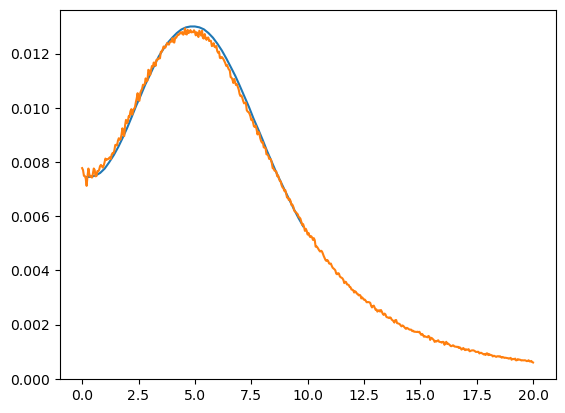

In [7]:
Rey = Re

if Rey == 100 or Rey == 800:
    csv_file_path = f'/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re{Rey}.csv'
    csv_data = []
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file, delimiter=';')
        for row in csv_reader:
            csv_data.append(row)
    csv_data = np.array(csv_data, dtype=float).T
elif Rey == 1600:
    csv_file_path = f"/home/ben/Schreibtisch/Referenz/Re{Rey}.csv"
    csv_data = np.genfromtxt(csv_file_path, delimiter=";", dtype=str)
    csv_data = np.char.replace(csv_data, ',', '.').astype(float).T
else:
    csv_data = np.loadtxt(f"/home/ben/Schreibtisch/Referenz/Re{Rey}.csv", delimiter=",")

plt.plot(csv_data[0,:], csv_data[1,:])
plt.plot(dissipationEkin[0,:], dissipationEkin[1,:])

In [8]:
print(Precision)
if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16

# **Erste Simulation mit Float32 für Initialisierung**
lattice_32 = lt.Lattice(lt.D3Q27, device="cuda", dtype=torch.float32)
flow_32 = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice_32)

if collision_operator == "BGK":
    collision_32 = lt.BGKCollision(lattice_32, tau=np.float64(flow_32.units.relaxation_parameter_lu))
elif collision_operator == "KBC":
    collision_32 = lt.KBCCollision3D(lattice_32, tau=np.float64(flow_32.units.relaxation_parameter_lu))

streaming_32 = lt.StandardStreaming(lattice_32)
simulation_32 = lt.Simulation(flow=flow_32, lattice=lattice_32, collision=collision_32, streaming=streaming_32)

# **Initialisierung mit Float32**
simulation_32.initialize_f_neq()

# **Konvertiere `f` auf Float64**
f_64 = simulation_32.f.to(torch.float64)
print(simulation_32.f.dtype)
print(f_64.dtype)

reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)

simulation.reporters.append(reporter)

steps = int(flow.units.convert_time_to_lu(tmax))


#simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))


# **Erstelle neue Simulation mit Float64**
lattice_64 = lt.Lattice(lt.D3Q27, device="cuda", dtype=torch.float64)
flow_64 = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice_64)

steps = int(flow.units.convert_time_to_lu(tmax))

if collision_operator == "BGK":
    collision_64 = lt.BGKCollision(lattice_64, tau=np.float64(np.float32(flow_32.units.relaxation_parameter_lu)))
elif collision_operator == "KBC":
    collision_64 = lt.KBCCollision3D(lattice_64, tau=np.float64(np.float32(flow_32.units.relaxation_parameter_lu)))

streaming_64 = lt.StandardStreaming(lattice_64)
simulation_64 = lt.Simulation(flow=flow_64, lattice=lattice_64, collision=collision_64, streaming=streaming_64)


Energy = lt.IncompressibleKineticEnergy(lattice=lattice_64, flow=flow_64)

reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)

simulation_64.reporters.append(reporter)

# **Setze `f` aus der Float32-Initialisierung in die neue Simulation**
simulation_64.f = f_64

# **Starte die Simulation mit Float64**
steps = int(flow_64.units.convert_time_to_lu(tmax))
mlups = simulation_64.step(num_steps=steps)

print("Performance in MLUPS:", mlups)
print(steps)
print(flow_64.units.relaxation_parameter_lu)

Double
torch.float32
torch.float64
steps     time     IncompressibleKineticEnergy
steps     time     IncompressibleKineticEnergy
Performance in MLUPS: 13.703256306302167
35285
0.5004410631163374


In [9]:
energy = np.array(simulation_64.reporters[0].out)
print(energy)
dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
dissipationEkininit=np.array([energy[:,1],-dEdt/(np.pi*2)**3])

[[0.00000000e+00 0.00000000e+00 3.10069481e+01]
 [7.00000000e+01 3.96768611e-02 3.09305893e+01]
 [1.40000000e+02 7.93537222e-02 3.08557216e+01]
 ...
 [3.51400000e+04 1.99177843e+01 1.35186224e+00]
 [3.52100000e+04 1.99574611e+01 1.34560718e+00]
 [3.52800000e+04 1.99971380e+01 1.33922092e+00]]


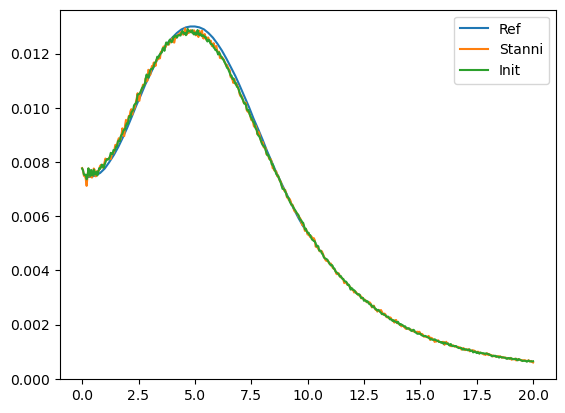

In [10]:
Rey = Re

if Rey == 100 or Rey == 800:
    csv_file_path = f'/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re{Rey}.csv'
    csv_data = []
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file, delimiter=';')
        for row in csv_reader:
            csv_data.append(row)
    csv_data = np.array(csv_data, dtype=float).T
elif Rey == 1600:
    csv_file_path = f"/home/ben/Schreibtisch/Referenz/Re{Rey}.csv"
    csv_data = np.genfromtxt(csv_file_path, delimiter=";", dtype=str)
    csv_data = np.char.replace(csv_data, ',', '.').astype(float).T
else:
    csv_data = np.loadtxt(f"/home/ben/Schreibtisch/Referenz/Re{Rey}.csv", delimiter=",")

plt.plot(csv_data[0,:], csv_data[1,:], label = 'Ref')
plt.plot(dissipationEkin[0,:], dissipationEkin[1,:], label = 'Stanni')
plt.plot(dissipationEkininit[0,:], dissipationEkininit[1,:], label = 'Init')
plt.legend()
plt.show()

0.0 0.0


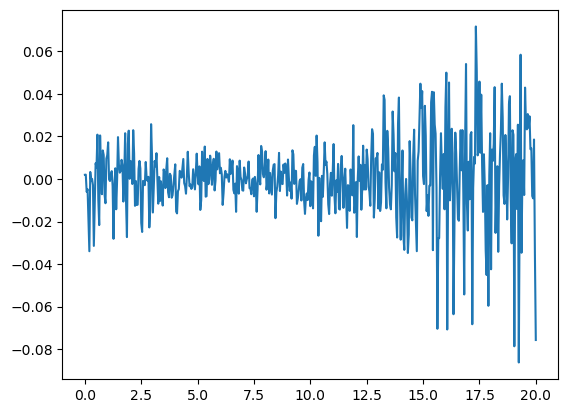

In [11]:
plt.plot(dissipationEkininit[0,:], (dissipationEkin[1,:]-dissipationEkininit[1,:])/dissipationEkin[1,:])

print(dissipationEkininit[0,0], dissipationEkin[0,0])

In [12]:
diff = np.float64(np.float32(flow_32.units.relaxation_parameter_lu)) - flow_64.units.relaxation_parameter_lu
print(diff)
print(simulation_32.f.dtype)
print(np.float64(np.float32(flow_32.units.relaxation_parameter_lu)))
print(flow_32.units.relaxation_parameter_lu)

tensor_32 = torch.tensor(1.0, dtype=torch.float32)  # PyTorch float32
numpy_64 = np.float64(2.0)  # NumPy float64

result = tensor_32 + numpy_64  # Addition zwischen torch.float32 und numpy.float64

print(result)
print(result.dtype)  # Ergebnis ist ein numpy.float64-Objekt!


1.1255000487153666e-08
torch.float32
0.5004410743713379
0.5004410631163374
tensor(3.)
torch.float32


In [13]:
import numpy as np

# Lange Zahl in Float64
long_number = 0.123456789123456789

# Umwandlung in Float64
num_float64 = np.float64(long_number)

# Umwandlung in Float32
num_float32 = np.float32(num_float64)

# Unterschied berechnen
diff = num_float64 - np.float64(num_float32)

# Ergebnisse in einem Dictionary speichern und anzeigen
results = {
    "Original Float64": num_float64,
    "Converted Float32": num_float32,
    "Difference": diff,
}

print(results)
import pandas as pd

df_results = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])


{'Original Float64': 0.12345678912345678, 'Converted Float32': 0.12345679, 'Difference': -1.919824771379197e-09}
